In [1]:
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import os
import copy
import random
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score, recall_score, accuracy_score, precision_score, f1_score

In [14]:
train_p = 'train_class'
test_p = 'val_class'

data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.RandomHorizontalFlip(p=0.4),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ]),
    "test": transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ])
}

data_dir = '/content/drive/MyDrive/emotions_ds'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, train_p),
                                          data_transforms[x])
                  for x in ['train', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=8)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


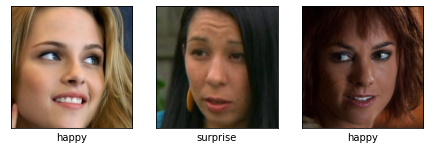

In [16]:
def show(images, labels):
  fig = plt.figure(figsize=(10,10))
  axes = []
  k = 0
  for i in range(3):
      axes.append(plt.subplot2grid((3, 4), (1, i)))
      inp = images[k]
      inp = inp.numpy().transpose((1, 2, 0))
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      inp = std * inp + mean
      inp = np.clip(inp, 0, 1)
      axes[k].set_xlabel(labels[k])
      axes[k].set_xticks([])
      axes[k].set_yticks([])
      plt.imshow(inp)
      k += 1
  plt.show()

X, y = next(iter(dataloaders['train']))
y = [class_names[x] for x in y[:3]]
show(X.to('cpu')[:3], y)

In [17]:
resnet_model = models.resnet152(pretrained=True)
resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
for param in resnet_model.parameters():
  param.requires_grad = False

resnet_model.fc = nn.Sequential(nn.Linear(2048, 128),
                                nn.ReLU(), nn.Linear(128, 8),
                                nn.LogSoftmax(dim=1))
resnet_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet_model.parameters()), lr=0.001)

def train_model(model, criterion, optimizer, epochs=3):
  model.train()
  hist = []
  for epoch in range(epochs):
    last_model = copy.deepcopy(model)
    print("Epoch {} / {}: ".format(epoch + 1, epochs))

    train_loss = 0.0
    for batch, (X, y) in enumerate(dataloaders['train']):
      X, y = X.to(device), y.to(device)

      optimizer.zero_grad()
      outputs = model(X)
      loss = criterion(outputs, y)
      loss.backward()
      optimizer.step()

      train_loss += loss.item() * X.size(0)
      
      if batch % 50 == 0:
        print(batch)
    
    train_loss = train_loss / len(image_datasets['train']) 
    print("Train Loss: ", train_loss)
    hist.append(train_loss)
  return model, hist

In [20]:
trained_model, resnet_history = train_model(resnet_model, loss, optimizer)

Epoch 1 / 3: 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0
50
100
150
200
250
300
350
400
450
500
550
Train Loss:  1.9000377184221624
Epoch 2 / 3: 
0
50
100
150
200
250
300
350
400
450
500
550
Train Loss:  1.791320072298724
Epoch 3 / 3: 
0
50
100
150
200
250
300
350
400
450
500
550
Train Loss:  1.7573601061441317


In [30]:
def predict(model, dataloader):

  all_preds = torch.tensor([]).to(device)
  true_vals = torch.tensor([]).to(device)

  with torch.no_grad():
    model.eval()
    for i, (X, y) in enumerate(dataloader):
      if i % 10 == 0:
        print(i)
      X, y = X.to(device), y.to(device)

      all_preds = torch.cat((all_preds, model(X)), 0)
      true_vals = torch.cat((true_vals, y), 0)
      
  return all_preds, true_vals

In [31]:
trained_model = trained_model.to(device)
outputs, labels = predict(trained_model, dataloaders['test'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580


In [32]:
_, outs = torch.max(outputs, dim=1)
print(classification_report(labels.cpu().numpy(), outs.cpu().numpy(), target_names=class_names))

              precision    recall  f1-score   support

       anger       0.27      0.50      0.35      5000
    contempt       0.32      0.26      0.29      3750
     disgust       0.25      0.34      0.29      3812
        fear       0.45      0.44      0.45      5000
       happy       0.49      0.49      0.49      5000
     neutral       0.32      0.33      0.33      5000
         sad       0.35      0.16      0.22      5003
    surprise       0.45      0.24      0.31      5000

    accuracy                           0.35     37565
   macro avg       0.36      0.34      0.34     37565
weighted avg       0.37      0.35      0.34     37565



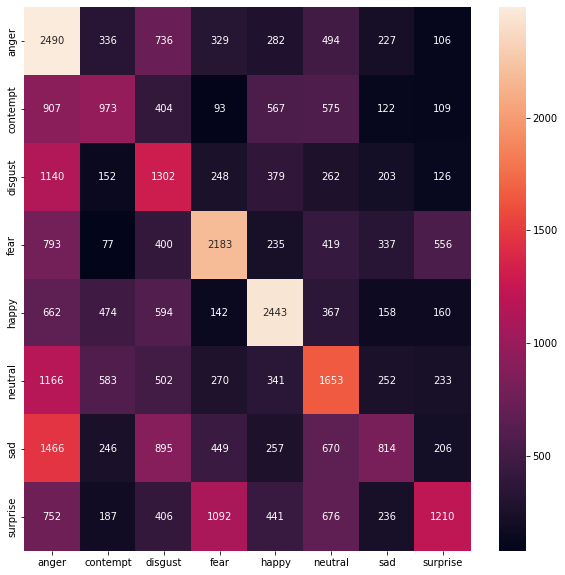

In [33]:
from seaborn import heatmap

confusion = confusion_matrix(labels.cpu().numpy(), outs.cpu().numpy())

fig = plt.figure(figsize=(10, 10))
heatmap(confusion,
        annot=True,
        fmt="d",
        xticklabels=list(class_names),
        yticklabels=list(class_names))

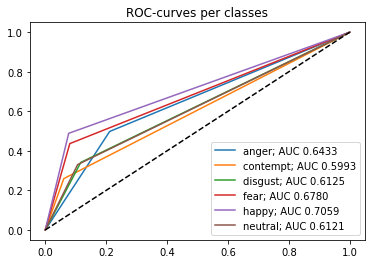

In [34]:
labels_plot = [(labels.cpu().numpy() == i).astype(float) for i in range(6)]
outs_plot = [(outs.cpu().numpy() == i).astype(float) for i in range(6)]
fpr_tpr = [roc_curve(labels_plot[i], outs_plot[i]) for i in range(6)]
roc_auc = [auc(fpr_tpr[i][0], fpr_tpr[i][1]) for i in range(6)]
plt.title('ROC-curves per classes')

for i in range(6):
  plt.plot(fpr_tpr[i][0], fpr_tpr[i][1], label = (class_names[i] + "; AUC " + "%.4f" % (roc_auc[i])))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'--', color = "black")
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


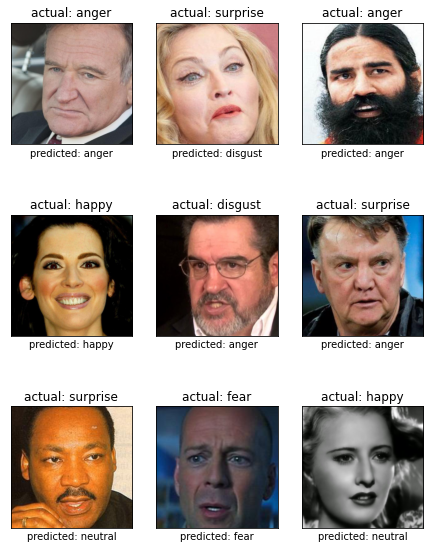

In [37]:
def show_pred(images, labels, predicts):
  fig = plt.figure(figsize=(10,10))
  axes = []
  k = 0
  for i in range(3):
    for j in range(3):
      axes.append(plt.subplot2grid((3, 4), (i, j)))
      inp = images[k]
      inp = inp.numpy().transpose((1, 2, 0))
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      inp = std * inp + mean
      inp = np.clip(inp, 0, 1)
      axes[k].set_title('actual: {}'.format(labels[k]))
      axes[k].set_xlabel('predicted: {}'.format(predicts[k]))
      axes[k].set_xticks([])
      axes[k].set_yticks([])
      plt.imshow(inp)
      k += 1
  plt.show()

X, y = next(iter(dataloaders['test']))
X = X.to(device)
probas = trained_model(X)
_, preds = torch.max(probas, dim=1)
y = [class_names[x] for x in y[:9]]
preds = [class_names[x] for x in preds[:9]]
show_pred(X.to('cpu')[:9], y, preds)

As a result, we received a model with an accuracy of less than 30 percent. It is less than in the case of landscapes. I think this is because the emotions of people are individual. Different people can show one emotion differently. Also in this dataset on all pictures are faces and the difference is essentially only in facial expressions. While in the dataset with landscapes, the pictures of different classes are completely different.  